In [5]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import cv2

try:
    from torchvision.io import read_video
except ImportError:
    raise ImportError("PyAV is not installed. Install it using: pip install av")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

# Dataset Preparation
class VideoDataset(Dataset):
    def __init__(self, folder_path, metadata_path, transform=None, num_frames=5):
        self.folder_path = folder_path
        self.transform = transform
        self.num_frames = num_frames
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        self.videos = list(self.metadata.keys())

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_name = self.videos[idx]
        video_path = os.path.join(self.folder_path, video_name)
        label = 1 if self.metadata[video_name]['label'] == 'FAKE' else 0

        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()
        while success and len(frames) < self.num_frames:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  # Convert to PIL Image
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            success, frame = cap.read()
        cap.release()

        # Pad with black frames if not enough frames
        while len(frames) < self.num_frames:
            frames.append(torch.zeros((3, 224, 224)))

        frames = torch.stack(frames[:self.num_frames])
        return frames, torch.tensor(label, dtype=torch.float32)

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Loading datasets
metadata_path = r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_videos\\metadata.json"
train_dataset = VideoDataset(r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_videos", metadata_path, transform=transform, num_frames=5)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)

# Model Definition (ResNet-18 as base)
class FakeVideoDetector(nn.Module):
    def __init__(self):
        super(FakeVideoDetector, self).__init__()
        self.resnet = resnet18(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        # Input shape: (B, F, C, H, W) -> ResNet processes single images
        B, F, C, H, W = x.size()
        x = x.view(B * F, C, H, W)  # Combine batch and frames
        x = self.resnet(x)
        x = x.view(B, F, -1).mean(dim=1)  # Average over frames
        return x

# Initialize model, loss, optimizer
model = FakeVideoDetector().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Device used: cuda
Epoch 1, Loss: 0.5920
Epoch 2, Loss: 0.5116
Epoch 3, Loss: 0.4689
Epoch 4, Loss: 0.4400
Epoch 5, Loss: 0.4498
Epoch 6, Loss: 0.4430
Epoch 7, Loss: 0.4277
Epoch 8, Loss: 0.4230
Epoch 9, Loss: 0.3817
Epoch 10, Loss: 0.3667
Epoch 11, Loss: 0.3666
Epoch 12, Loss: 0.3670
Epoch 13, Loss: 0.3665
Epoch 14, Loss: 0.3468
Epoch 15, Loss: 0.2923
Epoch 16, Loss: 0.2800
Epoch 17, Loss: 0.3165
Epoch 18, Loss: 0.3177
Epoch 19, Loss: 0.2945
Epoch 20, Loss: 0.2645
Epoch 21, Loss: 0.2602
Epoch 22, Loss: 0.2266
Epoch 23, Loss: 0.2234
Epoch 24, Loss: 0.2147
Epoch 25, Loss: 0.2174
Epoch 26, Loss: 0.1724
Epoch 27, Loss: 0.1613
Epoch 28, Loss: 0.1996
Epoch 29, Loss: 0.1584
Epoch 30, Loss: 0.1836
Epoch 31, Loss: 0.1691
Epoch 32, Loss: 0.1454
Epoch 33, Loss: 0.1393
Epoch 34, Loss: 0.1046
Epoch 35, Loss: 0.1186
Epoch 36, Loss: 0.1352
Epoch 37, Loss: 0.1077
Epoch 38, Loss: 0.1600
Epoch 39, Loss: 0.1231
Epoch 40, Loss: 0.1176
Epoch 41, Loss: 0.1069
Epoch 42, Loss: 0.1233
Epoch 43, Loss: 0.1012
Ep

In [6]:
# Save Model
torch.save(model.state_dict(), "fake_video_detector_more_epochs.pth")
print("Model saved successfully.")

Model saved successfully.


In [7]:
model.eval()  # Set the model to evaluation mode

FakeVideoDetector(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

C:\Users\yakup\AppData\Local\Temp\ipykernel_17132\2992311383.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_video_detector_more_

Classification Report:

              precision    recall  f1-score   support

        REAL       0.00      0.00      0.00        77
        FAKE       0.81      1.00      0.89       323

    accuracy                           0.81       400
   macro avg       0.40      0.50      0.45       400
weighted avg       0.65      0.81      0.72       400



c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 800x600 with 0 Axes>

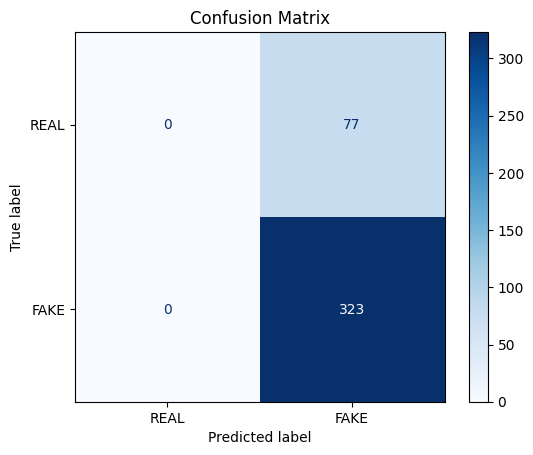

In [12]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming VideoDataset and transform are already defined

# Paths for validation dataset
validation_metadata_path = r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_videos\\metadata.json"
validation_folder_path = r"C:\\Users\\yakup\\OneDrive\\Desktop\\Special Dataset\\train_sample_video"

# Define validation dataset
validation_dataset = VideoDataset(
    validation_folder_path,
    validation_metadata_path,
    transform=transform,
    num_frames=5
)

# Validation DataLoader
validation_loader = DataLoader(
    validation_dataset,
    batch_size=4,  # Adjust as needed
    shuffle=False,  # No shuffling for validation
    num_workers=0,
    pin_memory=False
)

# Model setup
model = FakeVideoDetector()
model.load_state_dict(torch.load("fake_video_detector_more_epochs.pth"))
model.to(device)
model.eval()

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in validation_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        preds = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
report = classification_report(all_labels, all_preds, target_names=["REAL", "FAKE"])
print("Classification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [16]:
import cv2
import os
import torch
from torchvision.transforms import transforms
from PIL import Image

# Define the test folder path
test_folder = r"C:/Users/yakup/OneDrive/Desktop/Special Dataset/test_videos"

# Function to preprocess video frames
def preprocess_video(video_path, transform, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success and len(frames) < num_frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)  # Convert to PIL Image
        frame = transform(frame)
        frames.append(frame)
        success, frame = cap.read()
    cap.release()

    # Pad with black frames if not enough frames
    while len(frames) < num_frames:
        frames.append(torch.zeros((3, 224, 224)))

    frames = torch.stack(frames[:num_frames])
    return frames.unsqueeze(0)  # Add batch dimension

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load the trained model
model.load_state_dict(torch.load("fake_video_detector_more_epochs.pth"))
model.eval()

# Predict for each video
print("Predictions for test videos:\n")
for video_name in os.listdir(test_folder):
    video_path = os.path.join(test_folder, video_name)
    if not video_path.lower().endswith(('.mp4', '.avi', '.mov')):  # Check video file extensions
        continue

    try:
        # Preprocess video
        video_tensor = preprocess_video(video_path, transform).to(device)

        # Predict using the model
        with torch.no_grad():
            output = model(video_tensor)
            pred = (torch.sigmoid(output.squeeze()) > 0.5).int().item()

        # Map prediction to label
        label = "FAKE" if pred == 1 else "REAL"
        print(f"{video_name}: {label}")

    except Exception as e:
        print(f"Error processing {video_name}: {e}")


C:\Users\yakup\AppData\Local\Temp\ipykernel_17132\3835300011.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_video_detector_more_

Predictions for test videos:

aassnaulhq.mp4: FAKE
aayfryxljh.mp4: REAL
acazlolrpz.mp4: FAKE
adohdulfwb.mp4: REAL
ahjnxtiamx.mp4: REAL
ajiyrjfyzp.mp4: FAKE
aktnlyqpah.mp4: FAKE
alrtntfxtd.mp4: FAKE
aomqqjipcp.mp4: FAKE
apedduehoy.mp4: FAKE
apvzjkvnwn.mp4: FAKE
aqrsylrzgi.mp4: FAKE
axfhbpkdlc.mp4: FAKE
ayipraspbn.mp4: REAL
bcbqxhziqz.mp4: FAKE
bcvheslzrq.mp4: REAL
bdshuoldwx.mp4: REAL
bfdopzvxbi.mp4: REAL
bfjsthfhbd.mp4: FAKE
bjyaxvggle.mp4: FAKE
bkcyglmfci.mp4: REAL
bktkwbcawi.mp4: FAKE
bkuzquigyt.mp4: FAKE
blnmxntbey.mp4: FAKE
blszgmxkvu.mp4: FAKE
bnuwxhfahw.mp4: REAL
bofrwgeyjo.mp4: FAKE
btdxnajogv.mp4: FAKE
bvpeerislp.mp4: REAL
bwdmzwhdnw.mp4: FAKE
bzvzpwrabw.mp4: FAKE
cekarydqba.mp4: FAKE
cekwtyxdoo.mp4: FAKE
cjkctqqakb.mp4: FAKE
cnpanmywno.mp4: REAL
cnxccbjlct.mp4: FAKE
coqwgzpbhx.mp4: REAL
cosghhimnd.mp4: FAKE
coujjnypba.mp4: FAKE
cqhwesrciw.mp4: FAKE
cqxxumarvp.mp4: FAKE
csnkohqxdv.mp4: FAKE
cxsvvnxpyz.mp4: FAKE
czfqlbcfpa.mp4: REAL
dcqodpzomd.mp4: FAKE
ddtbarpcgo.mp4: FAKE
demu